In [1]:
import gym
import numpy as np
import tensorflow as tf
from scipy.stats import zscore
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt


physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Policy Gradient RL

DQN is a value based method. It approximates the action value function and from that, it derives a policy.

What if we wanted to learn the policy itself?

Why would we want to do that? Why is DQN not enough?

First of all, DQNs approximate the action value function. Sometimes, a value function can be very complex making it unfeasable to learn. Secondly, DQNs produce deterministic policies, with policy gradient methods we can generate stochastic policies

## Agent

We want to maximize the expected discounted cumulative reward. Let us define the function 

$$
J(\Theta)=E[\sum_t y^tR_t]
$$

that maps the parameters $\Theta$ of our neural network to this expected discounted cumulative reward. Now, if we would want to update our networks wieghts to maximize this value, we could simply do a gradient ascent:

$$
\Theta \leftarrow \Theta + \nabla_\Theta J(\Theta)
$$

As it turns out, after some derivation (well explained here: https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63) the gradient that we would need is equal to

$$
\nabla_\Theta J(\Theta) = \sum_t \nabla_\Theta \log \pi_\Theta (a_t | s_t) G_t
$$

with $G_t$ the discounted cumulative reward as of time step $t+1$import gym
import numpy as np
import tensorflow as tf
from scipy.stats import zscore
import random


physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True).

Luckily, the expression (let us call it the log policy)

$$
\log \pi_\Theta (a_t | s_t)
$$

is exactly the negated cross entropy of the probability distribution of the action taken at time step t (basically a one-hot encoding of $a_t$) and the probability distribution over the actions from our current policy given the state $s_t$. Since our policy is a neural network, we can differenciate it, thus we can also calculate the gradients we need.

So basically, if we complete an episode, and record all the states we have visited, all the actions we have taken and all the rewards we have received, we can calculate the discounted cumulative reward and we can plug everything into the equation above. Additionally, since we would use cross entropy to calculate the log policy, it is already negated, thus we can simply use gradient descent as usual.

So let's get to the implementation

In [2]:
class PolicyGradientN(tf.keras.layers.Layer):
    def __init__(self, units=(12, 12), n_actions=2, **kwargs):
        super(PolicyGradientN, self).__init__(**kwargs)
        self.layers = []
        for u in units:
            self.layers.append(tf.keras.layers.Dense(u, activation='relu'))
        self.layers.append(tf.keras.layers.Dense(n_actions))

            
    def call(self, inputs, **kwargs):
        outputs = inputs
        for l in self.layers:
            outputs = l(outputs)
        return outputs
    
class PolicyGradientAgent:
    def __init__(self, action_space):
        self.action_space = action_space
        self.model = PolicyGradientN(n_actions=self.action_space.n)
        self.optimizer = tf.keras.optimizers.Adam()
        
    def act(self, observation):
        probs = tf.nn.softmax(self.model(observation)).numpy()
        probs = np.squeeze(probs)
        return probs
        
    def learn(self, states, actions, discounted_cumulated_rewards):
        with tf.GradientTape() as tape:
            probs = self.model(states)
            log_policy = tf.nn.sparse_softmax_cross_entropy_with_logits(actions, probs)
            loss = tf.reduce_mean(discounted_cumulated_rewards * log_policy)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss.numpy()

NameError: name 'tf' is not defined

You might have noticed, that we have no $\epsilon$ greedy policy, we have no explore flag in the act method. The reason for that is, that we already have a stochastic policy. We sample from a distribution, thus there is allways some probability to chosing different actions given a state. 

## Training

We have no replay buffer for training policy gradient methods. We allways complete a full episode, record the trajectory and the rewards. We then use these to update our network. 

In [3]:
def compute_avg_return(env, agent, num_episodes=1, max_steps=200, render=False):
    total_return = 0.0
    for _ in range(num_episodes):
        obs, _ = env.reset()
        episode_return = 0.0
        done = False
        steps = 0
        while not (done or steps > max_steps):
            if render:
                clear_output(wait=True)
                plt.axis('off')
                plt.imshow(env.render())
                plt.show()
            probs = agent.act(np.array([obs]))
            action = np.random.choice(env.action_space.n, p=probs)
            obs, r, done, _, _ = env.step(action)
            episode_return += r
            steps += 1
        total_return += episode_return
    return total_return / num_episodes

In [4]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

agent = PolicyGradientAgent(env.action_space)

for i in range(1601):
    obs, _ = env.reset()
    done = False
    
    states = []
    rewards = []
    actions = []
    
    # steps = 0
    while not done:
        # steps += 1
        probs = agent.act(np.array([obs]))
        action = np.random.choice(env.action_space.n, p=probs)
        # execute action
        new_obs, r, done, _, _ = env.step(action)
        # if done and steps < env._max_episode_steps: 
            # r = -100
        states.append(obs)
        rewards.append(r)
        actions.append(action)
        obs = new_obs
    
    # compute the discounted cumulated rewards for the whole epoch
    discounted_cumulated_rewards = np.zeros_like(rewards)
    s = 0.0
    for j in reversed(range(len(rewards))):
        s = s * 0.99 + rewards[j]
        discounted_cumulated_rewards[j] = s
    # to make the training more stable, we compute the zscore of the discounted cumulated rewards 
    discounted_cumulated_rewards = zscore(discounted_cumulated_rewards)

    # shuffle the training data
    temp = list(zip(states, discounted_cumulated_rewards, actions))
    random.shuffle(temp)
    states, discounted_acc_rewards, actions = zip(*temp)
    loss = agent.learn(np.array(states), actions, discounted_acc_rewards)
    
    if i % 200 == 0:
        avg_return = compute_avg_return(env, agent, num_episodes=10)
        print(f'episode {i}, loss {loss}, avg_return {avg_return}')

D:\Users\gerge\Anaconda3\envs\tacs39\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode 0, loss -0.00846489705145359, avg_return 24.3
episode 200, loss -0.04024069011211395, avg_return 30.1
episode 400, loss -0.041260480880737305, avg_return 38.0
episode 600, loss -0.020791558548808098, avg_return 112.0
episode 800, loss 0.003930295817553997, avg_return 164.3
episode 1000, loss 0.01200598943978548, avg_return 181.9
episode 1200, loss -0.025472665205597878, avg_return 189.2
episode 1400, loss -0.0229265708476305, avg_return 200.8
episode 1600, loss -0.014855661429464817, avg_return 201.0


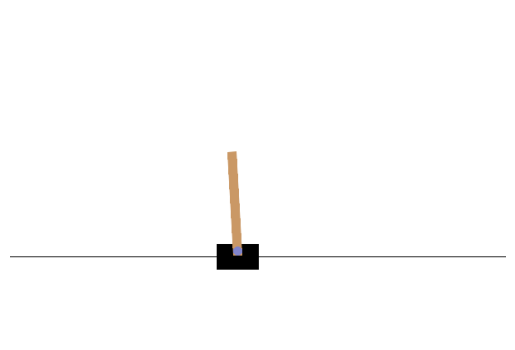

In [14]:
compute_avg_return(env, agent, num_episodes=2, render=True)
env.close()